## Importing Libraries

In [1]:
## Importing Libraries
import os
import gc
import glob
import random
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from pathlib import Path
from itertools import groupby
import matplotlib.pyplot as plt

import joblib
import pickle

from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression

reg_dict = {"LinearRegression": LinearRegression(),
            "Ridge": Ridge(),
            "Lasso": Lasso(),
            "ElasticNet": ElasticNet(), 
            "Polynomial_deg2": Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression())]),
            "Polynomial_deg3": Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression())]),
            "Polynomial_deg4": Pipeline([('poly', PolynomialFeatures(degree=4)),('linear', LinearRegression())]),
            "Polynomial_deg5": Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression())]),
            "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=3),
            "DecisionTreeRegressor": DecisionTreeRegressor(),
            "RandomForestRegressor": RandomForestRegressor(),
            "SVR": SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=0.1),
            "GaussianProcessRegressor": GaussianProcessRegressor(),
            "SGDRegressor": SGDRegressor(),
            "MLPRegressor": MLPRegressor(hidden_layer_sizes=(10,10), max_iter=100, early_stopping=True, n_iter_no_change=5),
            "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100), 
            "PLSRegression": PLSRegression(n_components=10),
            "PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=100, tol=1e-3),
            "TheilSenRegressor": TheilSenRegressor(random_state=0),
            "RANSACRegressor": RANSACRegressor(random_state=0),
            "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
            "AdaBoostRegressor": AdaBoostRegressor(random_state=0, n_estimators=100),
            "BaggingRegressor": BaggingRegressor(base_estimator=SVR(), n_estimators=10),
            "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
            "VotingRegressor": VotingRegressor([('lr', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=10))]),
            "StackingRegressor": StackingRegressor(estimators=[('lr', RidgeCV()), ('svr', LinearSVR())], final_estimator=RandomForestRegressor(n_estimators=10)),
            "ARDRegression": ARDRegression(),
            "HuberRegressor": HuberRegressor(),
                    }


/Users/shotomorisaki/Engineering/CSTD/env/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Read a data

In [2]:
st = pd.read_csv('../archive/shopping_trends.csv')
st.sample(5)

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
2535,2536,47,Male,Coat,Outerwear,80,Vermont,S,Purple,Winter,3.9,No,Bank Transfer,Express,No,No,39,Bank Transfer,Fortnightly
1557,1558,27,Male,Backpack,Accessories,34,South Dakota,L,Magenta,Fall,3.5,No,PayPal,Next Day Air,Yes,Yes,34,PayPal,Quarterly
1772,1773,58,Male,Shoes,Footwear,34,Hawaii,M,Gold,Summer,3.1,No,PayPal,2-Day Shipping,No,No,1,Bank Transfer,Annually
1640,1641,65,Male,Scarf,Accessories,51,Tennessee,S,Magenta,Spring,4.0,No,Debit Card,2-Day Shipping,Yes,Yes,13,PayPal,Weekly
3763,3764,27,Female,Shirt,Clothing,24,Oklahoma,XL,Red,Winter,4.5,No,PayPal,Standard,No,No,38,Cash,Every 3 Months


## Data Preprocessing
Cheking data types, checking data loss, any nun? 

In [3]:
st.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


In [4]:
st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 14  Discount

In [5]:
st.describe()

,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,1950.500000,44.068462,59.764359,3.749949,25.351538
std,1125.977353,15.207589,23.685392,0.716223,14.447125
min,1.000000,18.000000,20.000000,2.500000,1.000000
25%,975.750000,31.000000,39.000000,3.100000,13.000000
50%,1950.500000,44.000000,60.000000,3.700000,25.000000
75%,2925.250000,57.000000,81.000000,4.400000,38.000000
max,3900.000000,70.000000,100.000000,5.000000,50.000000


In [6]:
st.dtypes

Customer ID                   int64
Age                           int64
Gender                       object
Item Purchased               object
Category                     object
Purchase Amount (USD)         int64
Location                     object
Size                         object
Color                        object
Season                       object
Review Rating               float64
Subscription Status          object
Payment Method               object
Shipping Type                object
Discount Applied             object
Promo Code Used              object
Previous Purchases            int64
Preferred Payment Method     object
Frequency of Purchases       object
dtype: object

In [7]:
columns = ['Gender', 'Item Purchased', 'Category', 'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season', 'Review Rating',
                        'Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 
                        'Payment Method', 'Frequency of Purchases']

df = st[columns]
df.head(-5)

,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Payment Method,Frequency of Purchases
0,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,Credit Card,Fortnightly
1,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,Bank Transfer,Fortnightly
2,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,Cash,Weekly
3,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,PayPal,Weekly
4,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,Cash,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3890,Female,Shirt,Clothing,81,Nebraska,XL,Green,Winter,2.6,No,Standard,No,No,Credit Card,Annually
3891,Female,Dress,Clothing,30,Colorado,L,Peach,Winter,4.7,No,Free Shipping,No,No,Cash,Quarterly
3892,Female,Jewelry,Accessories,86,Michigan,L,Indigo,Summer,3.5,No,Standard,No,No,Bank Transfer,Fortnightly
3893,Female,Hat,Accessories,64,Massachusetts,L,White,Fall,3.3,No,Store Pickup,No,No,Bank Transfer,Bi-Weekly


In [8]:
df.dtypes

Gender                     object
Item Purchased             object
Category                   object
Purchase Amount (USD)       int64
Location                   object
Size                       object
Color                      object
Season                     object
Review Rating             float64
Subscription Status        object
Shipping Type              object
Discount Applied           object
Promo Code Used            object
Payment Method             object
Frequency of Purchases     object
dtype: object

In [9]:
df.isnull().sum()
#データ内に欠損値があるかどうかを確認

Gender                    0
Item Purchased            0
Category                  0
Purchase Amount (USD)     0
Location                  0
Size                      0
Color                     0
Season                    0
Review Rating             0
Subscription Status       0
Shipping Type             0
Discount Applied          0
Promo Code Used           0
Payment Method            0
Frequency of Purchases    0
dtype: int64

In [10]:
train_x = df.copy()#コピーを作成する
train_x = train_x.drop([], axis=1)# 指定した行を削除
display(train_x)#データを表示

,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Payment Method,Frequency of Purchases
0,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,Credit Card,Fortnightly
1,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,Bank Transfer,Fortnightly
2,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,Cash,Weekly
3,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,PayPal,Weekly
4,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,Cash,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,2-Day Shipping,No,No,Cash,Weekly
3896,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,Store Pickup,No,No,PayPal,Bi-Weekly
3897,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Standard,No,No,Credit Card,Quarterly
3898,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,Express,No,No,PayPal,Weekly


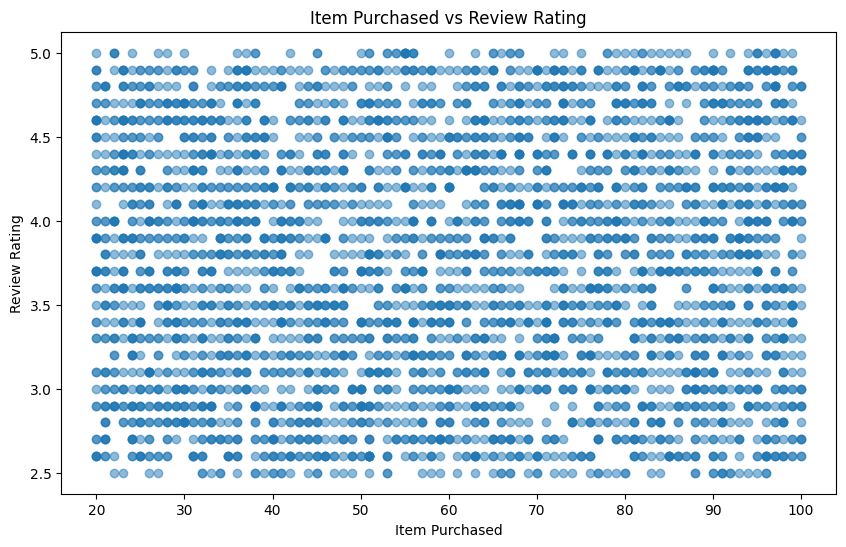

In [21]:
x_axis = df['Purchase Amount (USD)']
y_axis = df['Review Rating']

plt.figure(figsize=(10, 6))
plt.scatter(x_axis, y_axis, alpha=0.5)
plt.title('Item Purchased vs Review Rating')
plt.xlabel('Item Purchased')
plt.ylabel('Review Rating')
plt.show()


In [11]:
train_x.isnull().sum()

Gender                    0
Item Purchased            0
Category                  0
Purchase Amount (USD)     0
Location                  0
Size                      0
Color                     0
Season                    0
Review Rating             0
Subscription Status       0
Shipping Type             0
Discount Applied          0
Promo Code Used           0
Payment Method            0
Frequency of Purchases    0
dtype: int64

In [12]:
from sklearn.preprocessing import LabelEncoder
non_numeric_columns = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season',
                        'Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 
                        'Payment Method', 'Frequency of Purchases']

for col in non_numeric_columns:
    encoder = LabelEncoder()
    encoder.fit(df[col])
    df[col] = encoder.transform(df[col])
    train_x[col] = encoder.transform(train_x[col])

df

/var/folders/_n/zkwnlxm959j1s3pt15cz_xmw0000gn/T/ipykernel_42946/2877821526.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = encoder.transform(df[col])
/var/folders/_n/zkwnlxm959j1s3pt15cz_xmw0000gn/T/ipykernel_42946/2877821526.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = encoder.transform(df[col])
/var/folders/_n/zkwnlxm959j1s3pt15cz_xmw0000gn/T/ipykernel_42946/2877821526.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Payment Method,Frequency of Purchases
0,1,2,1,53,16,0,7,3,3.1,1,1,1,1,2,3
1,1,23,1,64,18,0,12,3,3.1,1,1,1,1,0,3
2,1,11,1,73,20,2,12,1,3.1,1,2,1,1,1,6
3,1,14,2,90,38,1,12,1,3.5,1,3,1,1,4,6
4,1,2,1,49,36,1,21,1,2.7,1,2,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,0,9,1,28,45,0,21,2,4.2,0,0,0,0,1,6
3896,0,0,0,49,14,0,23,1,4.5,0,5,0,0,4,1
3897,0,1,0,33,29,0,8,1,2.9,0,4,0,0,2,5
3898,0,17,2,77,22,2,3,2,3.8,0,1,0,0,4,6


## Feature Engineering

In [13]:
columns

['Gender',
 'Item Purchased',
 'Category',
 'Purchase Amount (USD)',
 'Location',
 'Size',
 'Color',
 'Season',
 'Review Rating',
 'Subscription Status',
 'Shipping Type',
 'Discount Applied',
 'Promo Code Used',
 'Payment Method',
 'Frequency of Purchases']

In [14]:
from sklearn.model_selection import train_test_split

# Assuming your target variable is 'Purchase Amount (USD)'
target_variable = 'Review Rating'
X = train_x.drop(target_variable, axis=1)
y = train_x[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
x_pred = model.predict(X_test)



In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, x_pred)
mae = mean_absolute_error(y_test, x_pred)
r2 = r2_score(y_test, x_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.5441881781558963
Mean Absolute Error: 0.6465107620567536
R-squared: 0.0019666885925604394


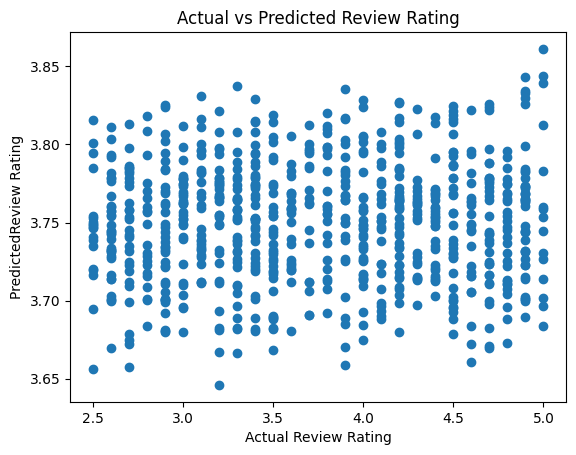

In [17]:
import matplotlib.pyplot as plt

plt.scatter(y_test, x_pred)
plt.xlabel('Actual Review Rating')
plt.ylabel('PredictedReview Rating')
plt.title('Actual vs Predicted Review Rating')
plt.show()
